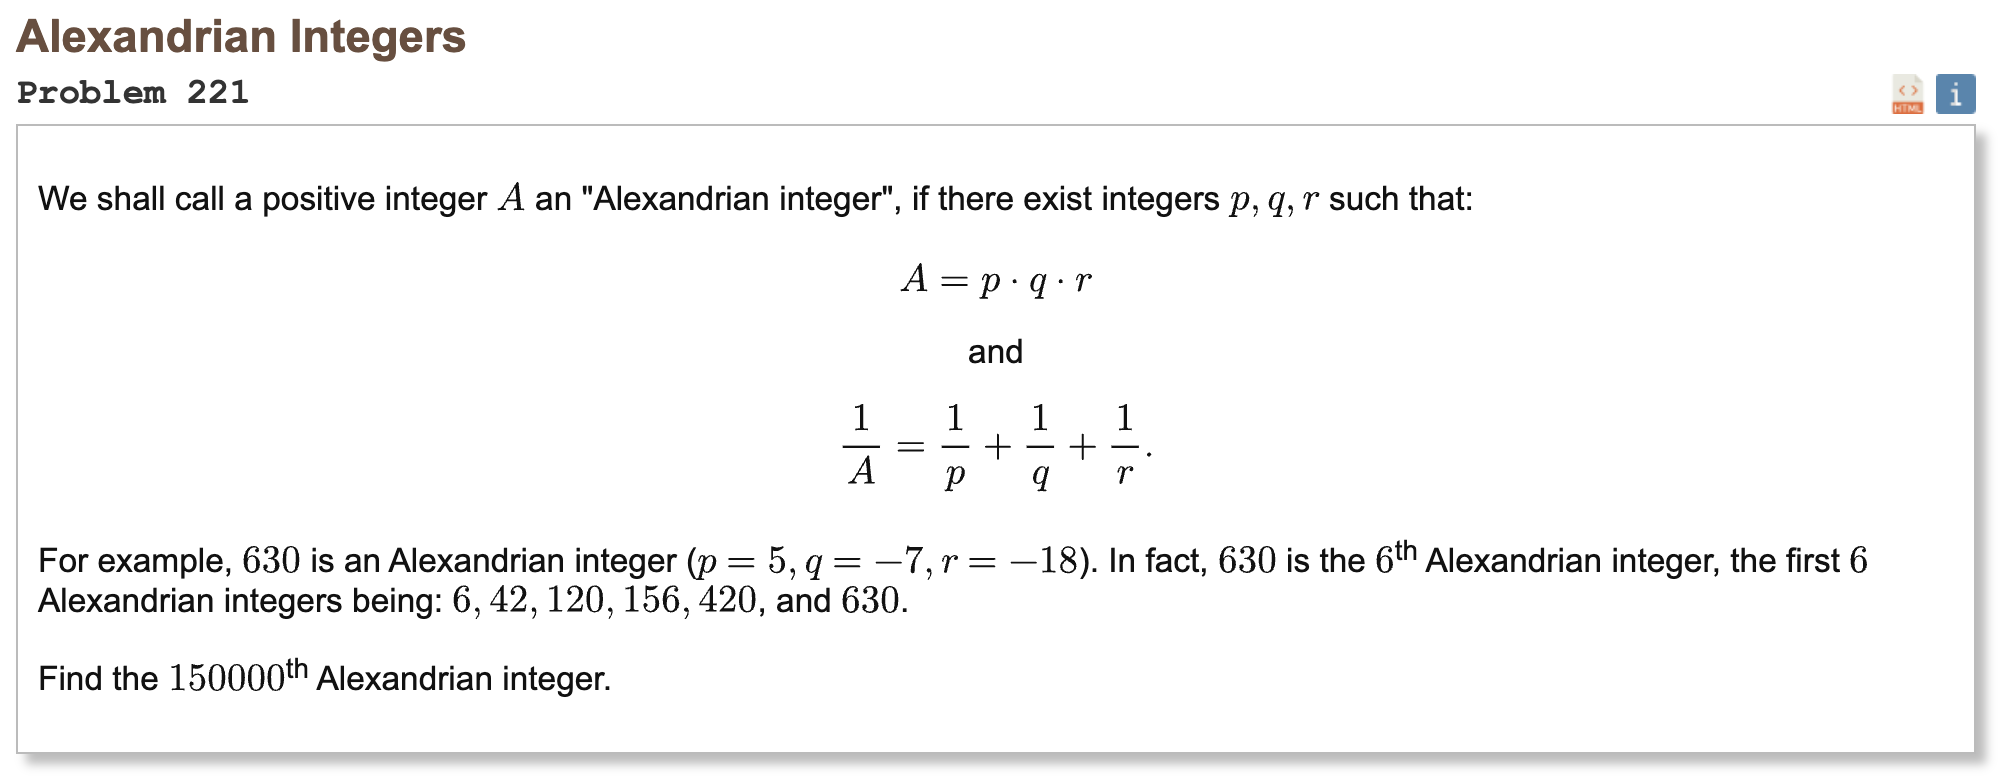

## Initial approach

* rewrite the rule so it depends on three numbers whose product is positive
* this forces two numbers to be negative and one to be positive
* switch signs so we only work with positive numbers
* this turns the problem into finding pairs that fit a simple divisibility pattern
* for a fixed starting number, all valid results come from divisors of one related value
* each starting number gives a sorted list of candidates
* merge all lists in increasing order and count until reaching the target index

In [1]:
import heapq
import math

def sieve_primes(n):
    if n < 2:
        return []
    is_prime = bytearray(b"\x01") * (n + 1)
    is_prime[0:2] = b"\x00\x00"
    m = int(n ** 0.5)
    for p in range(2, m + 1):
        if is_prime[p]:
            step = p
            start = p * p
            is_prime[start:n + 1:step] = b"\x00" * (((n - start) // step) + 1)
    return [i for i in range(2, n + 1) if is_prime[i]]

class PrimeCache:
    def __init__(self):
        self.limit = 1
        self.primes = []

    def ensure(self, n):
        if n <= self.limit:
            return
        self.primes = sieve_primes(n)
        self.limit = n

def factorize(n, pc):
    if n <= 1:
        return {}
    lim = int(math.isqrt(n))
    pc.ensure(lim)
    x = n
    fac = {}
    for p in pc.primes:
        if p * p > x:
            break
        if x % p == 0:
            e = 0
            while x % p == 0:
                x //= p
                e += 1
            fac[p] = e
    if x > 1:
        fac[x] = fac.get(x, 0) + 1
    return fac

def all_divisors_from_factors(fac):
    divs = [1]
    for p, e in fac.items():
        pe = 1
        cur = []
        for _ in range(e):
            pe *= p
            for d in divs:
                cur.append(d * pe)
        divs.extend(cur)
    return divs

def candidates_for_a(a, pc):
    n = a * a + 1
    fac = factorize(n, pc)
    divs = all_divisors_from_factors(fac)
    res = []
    for d in divs:
        if 1 <= d < a:
            b = n // d - a
            if b < a:
                continue
            k = a - d
            if k <= 0:
                continue
            A = a * b * k
            res.append(A)
    if not res:
        return []
    res = sorted(set(res))
    return res

def lower_bound_for_a(a):
    return (a * a * a - a) // 2

def alexandrian_kth(k_target):
    pc = PrimeCache()
    heap = []
    cand = {}
    next_a = 1
    seen = set()
    count = 0
    last = None

    def add_a(a):
        lst = candidates_for_a(a, pc)
        if lst:
            cand[a] = lst
            heapq.heappush(heap, (lst[0], a, 0))

    add_a(next_a)
    next_a += 1

    while count < k_target:
        while not heap or lower_bound_for_a(next_a) <= heap[0][0]:
            add_a(next_a)
            next_a += 1

        val, a, idx = heapq.heappop(heap)
        if val not in seen:
            seen.add(val)
            count += 1
            last = val

        idx += 1
        if a in cand and idx < len(cand[a]):
            heapq.heappush(heap, (cand[a][idx], a, idx))

    return last

In [2]:
%%time
result = alexandrian_kth(150000)
print("Result:", result)

Result: 1884161251122450
CPU times: user 4min 40s, sys: 1.72 s, total: 4min 41s
Wall time: 4min 42s
